In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

In [49]:
df = pd.read_csv("oup_discipline.csv")

# Первая часть

В начале я пробовала использовать метрику RMSE (потом перешла на более удобную, но в начале несколько экспериментов с ней).

Также данные просто смешивались в куче и брались train_test_split.

Сначала бейзлайн:

In [46]:
easy_pred = [y_train.mean()] * len(y_test)
mean_squared_error(y_test, easy_pred, squared=False)

49.738082451167266

Теперь нормальные эксперименты:

In [50]:
all_columns = set(df.columns)
delete_columns = set(["StudLearnCount", "BachStudCount", "MagStudCount", "ID", "ProposalItem", "MasterItem", "MasterItemPos"])
categorical_columns = all_columns - delete_columns - set(["StudCount"])
numeric_columns = ["StudCount"]

X = df[np.array(all_columns - delete_columns)]
y = df["StudLearnCount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
def base_algo(numeric_col, categor_col, no_coef=False, method=Ridge(), error_func=mean_squared_error, params_for_error={}):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categor_col),
        ('scaling', StandardScaler(), numeric_col)
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', method)
    ])

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    err = error_func(y_test, y_pred, **params_for_error)
    print("Method:", method, "\n")
    print("Error:", error_func)
    print(err, "\n")
    if no_coef:
        return model
    coefs = model.named_steps['regression'].coef_
    print("Coefs:")
    for i in coefs:
        print(i)
    return model

In [8]:
base_algo(["StudCount"], [], params_for_error={"squared": False})

Method: Ridge() 

Error: <function mean_squared_error at 0x7f958ee0dd30>
31.971086371589404 

Coefs:
50.50413973703333


Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  []),
                                                 ('scaling', StandardScaler(),
                                                  ['StudCount'])])),
                ('regression', Ridge())])

Пробуем добавить еще признаков:

In [50]:
base_algo(["StudCount"], ["WithOnlineCourse", "ItemLearnYear_D"], params_for_error={"squared": False})

Method: Ridge() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
31.932715768073177 

Coefs:
-1.16538917977444
1.1653891797746563
3.433978418364064
0.12656693297664046
-3.560545351314346
50.55441420135785


Давайте попробуем поиспользовать Credits и PracticeHours, но для этого надо решить, что делать с проблеми ("None").
Для Credits проблема решена выше - заменили на 0 (это в основном физкультура, логично, что она не имеет веса).
Предлагаю для PracticeHours и тд тоже заменить на 0 и потестить.

In [51]:
base_algo(["StudCount", "Credits"], ["WithOnlineCourse", "ItemLearnYear_D"], params_for_error={"squared": False})

Method: Ridge() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
31.961100948837455 

Coefs:
-1.2970410973180722
1.297041097318243
3.4138668894503965
0.13247811247546215
-3.546345001899121
50.56245034942134
-0.790465323570226


Видно, что самые большие дельты у Английского языка(в том или ином виде). Давайте попробуем добавить факультет:

In [52]:
base_algo(["StudCount", "Credits"], ["Description"], no_coef=True, params_for_error={"squared": False})

Method: Ridge() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
32.30016017583393 



In [53]:
base_algo(["StudCount"], ["EdLevel_D", "ItemCourse_D"], no_coef=True, params_for_error={"squared": False})

Method: Ridge() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
31.053559446075898 



In [54]:
base_algo(
    ["StudCount"],
    ["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    no_coef=True, params_for_error={"squared": False})

Method: Ridge() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
31.008989943556177 



Дрбавили так называемые "корзины" - взяли логарифм от StudCount, чтобы разделть веса на тяжелые и легкие.

In [55]:
base_algo(
    ["StudCount"],
    ["StudCountBins"],
    no_coef=False, params_for_error={"squared": False})

Method: Ridge() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
33.171345666821814 

Coefs:
84.34209905100354
24.302301578900092
26.274534771643047
29.059015854428985
41.13867161635022
75.84951459548952
180.66621236453105
-513.7592892245956
52.12693939008375
48.532050178995924


Пробуем простое решающее дерево и градиентный бустинг:

In [58]:
base_algo(
    ["StudCount"],
    ["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    method=DecisionTreeRegressor(),
    no_coef=True, params_for_error={"squared": False})

Method: DecisionTreeRegressor() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
70.78357889472663 



In [60]:
base_algo(
    ["StudCount", "EntireHours"],
    ["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D", "StudCountBins", "WithOnlineCourse"],
    method=GradientBoostingRegressor(),
    no_coef=True, params_for_error={"squared": False})

Method: GradientBoostingRegressor() 

Error: <function mean_squared_error at 0x7f0f48e83c10>
37.65608950346666 



# Вторая часть

Пробуем изменить метрику на процент ошибки относительно правильного ответа:

In [12]:
def part_error(y_test, y_pred):
    y_test[y_test == 0] = 1
    res = y_pred / y_test
    res = abs(1 - res)
    return res.mean()

In [69]:
base_algo(
    ["StudCount"],
    [],
    error_func=part_error)

Method: Ridge() 

Error: <function part_error at 0x7f0f40fbce50>
2.995311588933207 

Coefs:
50.50413973703333


In [27]:
base_algo(
    ["StudCount"],
    ["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    error_func=part_error,
)

Method: Ridge() 

Error: <function part_error at 0x7fb244515a60>
2.6387213237249103 

Coefs:
-26.748007361766742
28.99335153415839
-10.402182077920306
8.156837904394441
26.782201477548085
-12.564997619108984
-13.021354944102995
-14.702651190570625
-15.195752989706099
-16.577126259194642
18.838381921122853
18.28446169985428
3.8943215609773536
4.262516343417086
3.7447551689806344
-0.25333504187391975
-3.4914201270610064
46.90796251311258


Прочитала про метрику SMAPE:

In [1]:
def smape(A, F):
    return np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))) / len(A)

Также я прочитала, что если мы берем в качестве регуляризатора L1, то часто много весов зануляется. Глобально, мы этого и хотим - положить кучу разных данных и занулить их потом. Так что попробуем поиспользовать Lasso:

In [14]:
base_algo(
    numeric_col=["StudCount"],
    categor_col=[],
    method=Lasso(),
    error_func=part_error)

Method: Lasso() 

Error: <function part_error at 0x7fb244515a60>
3.0483246017438477 

Coefs:
49.507908140237134


In [15]:
base_algo(
    numeric_col=["StudCount"],
    categor_col=["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    method=Lasso(),
    error_func=part_error)

Method: Lasso() 

Error: <function part_error at 0x7fb244515a60>
2.8209659134220844 

Coefs:
-5.740088905505539
8.454213789759486
-0.0
0.0
10.633986327516785
0.0
-0.0
-0.0
-0.0
-0.0
0.0
-0.0
0.0
0.0
0.31323208758413995
0.0
-0.6445818597535079
47.966927615745604


In [17]:
base_algo(
    numeric_col=["StudCount"],
    categor_col=["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    method=Lasso(alpha=0.5),
    error_func=part_error)

Method: Lasso(alpha=0.5) 

Error: <function part_error at 0x7fb244515a60>
2.696341775810879 

Coefs:
-24.21674679831957
8.281107759482296
-0.0
0.0
23.06672724930179
0.0
-0.0
-0.0
-0.0
-0.0
0.0
0.0
0.0
0.0
2.0824702469536533
0.0
-1.9401214094825177
47.552979588987974


In [22]:
df.dtypes

ID                             int64
ProposalItem                   int64
PlanClass_D                   object
EdLevel_D                     object
ItemCourse_D                  object
ItemLearnYear_D               object
StudCount                      int64
StudLearnCount                 int64
BachStudCount                  int64
MagStudCount                   int64
RegDepartment_D               object
Faculty_D                     object
LearnProgram_D                object
Description                   object
LongName                      object
SubjectClass_D                object
FacDepartment_D               object
FDFaculty_D                   object
FDRegDepartment_D             object
MasterItem                     int64
MasterItemPos                 object
ItemSource_D                  object
AudienceScope_D               object
Credits                        int64
EntireHours                    int64
LectionHours                   int64
SeminarHours                   int64
P

In [33]:
base_algo(
    numeric_col=["StudCount", "Credits", "EntireHours", "LectionHours", "SeminarHours", "PracticeHours"],
    categor_col=["PlanClass_D", "EdLevel_D", "ItemCourse_D", "ItemLearnYear_D", "PeriodNumList", "WithOnlineCourse"],
    method=Lasso(alpha=0.5),
    error_func=part_error)

Method: Lasso(alpha=0.5) 

Error: <function part_error at 0x7fb244515a60>
2.763400044181575 

Coefs:
0.0
0.0
-0.0
-10.273457948596782
-21.564376331170905
8.748725423121488
-0.0
0.0
10.756191294443562
0.0
0.0
-0.0
-0.3586826347611377
-0.0
0.0
0.0
0.0
0.0
1.1399056517268444
-0.0
-1.8894702394244856
-0.0
0.0
-0.0
0.0
0.0
-0.0
0.0
-0.0
0.0
-0.0
0.0
-0.0
-0.0
-0.0
212.81772248264016
-0.0
0.0
47.66407428773121
0.0
0.0
0.07777515234035015
0.006440698895365199
-0.7289882238825414


## Перейдем на SMAPE:

In [34]:
base_algo(
    numeric_col=["StudCount"],
    categor_col=[],
    method=Lasso(),
    error_func=smape)

Method: Lasso() 

Error: <function smape at 0x7fb28835a430>
0.6181089596732408 

Coefs:
49.507908140237134


In [35]:
base_algo(
    numeric_col=["StudCount"],
    categor_col=["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    method=Lasso(),
    error_func=smape)

Method: Lasso() 

Error: <function smape at 0x7fb28835a430>
0.6056611867156406 

Coefs:
-5.740088905505539
8.454213789759486
-0.0
0.0
10.633986327516785
0.0
-0.0
-0.0
-0.0
-0.0
0.0
-0.0
0.0
0.0
0.31323208758413995
0.0
-0.6445818597535079
47.966927615745604


In [36]:
base_algo(
    numeric_col=["StudCount"],
    categor_col=["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    method=Lasso(alpha=0.5),
    error_func=smape)

Method: Lasso(alpha=0.5) 

Error: <function smape at 0x7fb28835a430>
0.6069783290833942 

Coefs:
-24.21674679831957
8.281107759482296
-0.0
0.0
23.06672724930179
0.0
-0.0
-0.0
-0.0
-0.0
0.0
0.0
0.0
0.0
2.0824702469536533
0.0
-1.9401214094825177
47.552979588987974


In [37]:
base_algo(
    numeric_col=["StudCount", "Credits", "EntireHours", "LectionHours", "SeminarHours", "PracticeHours"],
    categor_col=["PlanClass_D", "EdLevel_D", "ItemCourse_D", "ItemLearnYear_D", "PeriodNumList", "WithOnlineCourse"],
    method=Lasso(alpha=0.5),
    error_func=smape)

Method: Lasso(alpha=0.5) 

Error: <function smape at 0x7fb28835a430>
0.6048528990263804 

Coefs:
0.0
0.0
-0.0
-10.273457948596782
-21.564376331170905
8.748725423121488
-0.0
0.0
10.756191294443562
0.0
0.0
-0.0
-0.3586826347611377
-0.0
0.0
0.0
0.0
0.0
1.1399056517268444
-0.0
-1.8894702394244856
-0.0
0.0
-0.0
0.0
0.0
-0.0
0.0
-0.0
0.0
-0.0
0.0
-0.0
-0.0
-0.0
212.81772248264016
-0.0
0.0
47.66407428773121
0.0
0.0
0.07777515234035015
0.006440698895365199
-0.7289882238825414


Попробуем DecisionTreeRegressor (с визуалиазацией):

In [45]:
base_algo(
    numeric_col=["StudCount", "Credits", "EntireHours", "LectionHours", "SeminarHours", "PracticeHours"],
    categor_col=["PlanClass_D", "EdLevel_D", "ItemCourse_D", "ItemLearnYear_D", "PeriodNumList", "WithOnlineCourse"],
    method=DecisionTreeRegressor(),
    no_coef=True,
    error_func=smape)

Method: DecisionTreeRegressor() 

Error: <function smape at 0x7fb28835a430>
0.6352356241191554 



Pipeline(steps=[('ohe_and_scaling',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['PlanClass_D', 'EdLevel_D',
                                                   'ItemCourse_D',
                                                   'ItemLearnYear_D',
                                                   'PeriodNumList',
                                                   'WithOnlineCourse']),
                                                 ('scaling', StandardScaler(),
                                                  ['StudCount', 'Credits',
                                                   'EntireHours',
                                                   'LectionHours',
                                                   'SeminarHours',
                                                   'PracticeHours'])])),
                ('regression', DecisionTreeRegressor())])

In [42]:
from sklearn import tree

In [54]:
model_tree = base_algo(
    numeric_col=["StudCount"],
    categor_col=[],
    method=DecisionTreeRegressor(),
    no_coef=True,
    error_func=smape)

Method: DecisionTreeRegressor() 

Error: <function smape at 0x7fb28835a430>
0.5833954238013328 



In [57]:
model_tree = base_algo(
    numeric_col=["StudCount"],
    categor_col=[],
    method=DecisionTreeRegressor(criterion="absolute_error"),
    no_coef=True,
    error_func=smape)

Method: DecisionTreeRegressor(criterion='absolute_error') 

Error: <function smape at 0x7fb28835a430>
0.5715934552496578 



In [58]:
model_tree = base_algo(
    numeric_col=["StudCount"],
    categor_col=[],
    method=DecisionTreeRegressor(criterion="absolute_error", max_depth=3),
    no_coef=True,
    error_func=smape)

Method: DecisionTreeRegressor(criterion='absolute_error', max_depth=3) 

Error: <function smape at 0x7fb28835a430>
0.601072193127812 



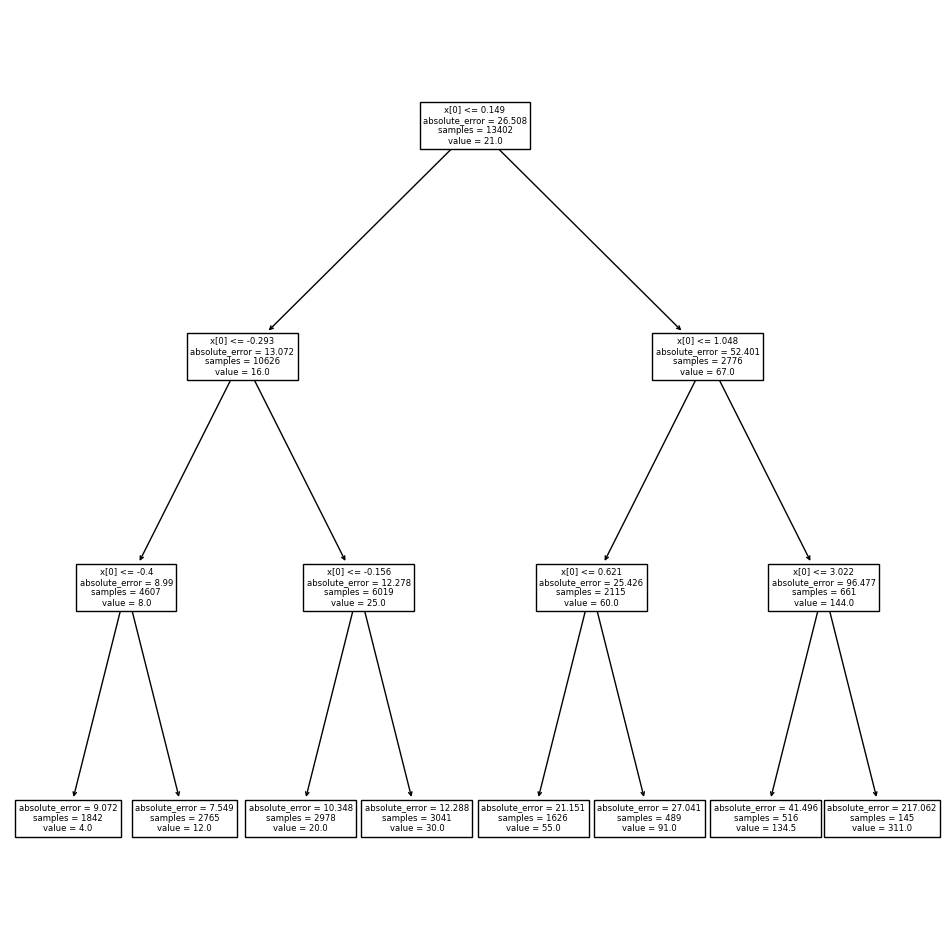

In [63]:
plt.figure(figsize=(12, 12))
tree.plot_tree(model_tree.named_steps['regression'])
plt.show()

In [67]:
model_tree = base_algo(
    numeric_col=["StudCount"],
    categor_col=["PlanClass_D", "EdLevel_D", "ItemCourse_D"],
    method=DecisionTreeRegressor(criterion="absolute_error"),
    no_coef=True,
    error_func=smape)

Method: DecisionTreeRegressor(criterion='absolute_error') 

Error: <function smape at 0x7fb28835a430>
0.5658210143509778 



In [68]:
model_tree = base_algo(
    numeric_col=["StudCount", "Credits", "EntireHours", "LectionHours", "SeminarHours", "PracticeHours"],
    categor_col=["PlanClass_D", "EdLevel_D", "ItemCourse_D", "ItemLearnYear_D", "PeriodNumList", "WithOnlineCourse"],
    method=DecisionTreeRegressor(criterion="absolute_error"),
    no_coef=True,
    error_func=smape)

Method: DecisionTreeRegressor(criterion='absolute_error') 

Error: <function smape at 0x7fb28835a430>
0.6329233134314386 



In [74]:
model_tree = base_algo(
    numeric_col=["StudCount", "Credits", "EntireHours", "LectionHours", "SeminarHours", "PracticeHours"],
    categor_col=["PlanClass_D", "EdLevel_D", "ItemCourse_D", "ItemLearnYear_D", "PeriodNumList", "WithOnlineCourse"],
    method=RandomForestRegressor(criterion="absolute_error"),
    no_coef=True,
    error_func=smape)

Method: RandomForestRegressor(criterion='absolute_error') 

Error: <function smape at 0x7fb28835a430>
0.5687225560106784 



# Попробуем MAE

In [14]:
base_algo(
    numeric_col=["StudCount"],
    categor_col=[],
    method=Lasso(),
    no_coef=True,
    error_func=mean_absolute_error)
print("")

Method: Lasso() 

Error: <function mean_absolute_error at 0x7f958ee0db80>
15.071180076563326 




In [15]:
base_algo(
    numeric_col=["StudCount"],
    categor_col=["EdLevel_D", "ItemCourse_D", "ItemLearnYear_D"],
    method=Lasso(),
    no_coef=True,
    error_func=mean_absolute_error)
print("")

Method: Lasso() 

Error: <function mean_absolute_error at 0x7f958ee0db80>
14.444248420328071 




In [17]:
model_tree = base_algo(
    numeric_col=["StudCount"],
    categor_col=["PlanClass_D", "EdLevel_D", "ItemCourse_D"],
    method=DecisionTreeRegressor(criterion="absolute_error"),
    no_coef=True,
    error_func=mean_absolute_error)

Method: DecisionTreeRegressor(criterion='absolute_error') 

Error: <function mean_absolute_error at 0x7f958ee0db80>
13.946475195822455 



# Добавим кросс-валидацию

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

In [42]:
def base_algo_with_validation(numeric_col, categor_col, no_coef=False, method=Ridge(), error_func=mean_squared_error, params_for_error={}):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categor_col),
        ('scaling', StandardScaler(), numeric_col)
    ])

#     pipeline = Pipeline(steps=[
#         ('ohe_and_scaling', column_transformer),
#         ('cross_val', cross_val_score(method))
#     ])

    X_2 = column_transformer.fit_transform(X)
#     model = pipeline.fit(X_train, y_train)
    score = cross_validate(method, X_2, y, cv=5, scoring=make_scorer(mean_absolute_error))
    print(score)
#     y_pred = model.predict(X_test)
#     err = error_func(y_test, y_pred, **params_for_error)
#     print("Method:", method, "\n")
#     print("Error:", error_func)
#     print(err, "\n")
#     if no_coef:
#         return model
#     coefs = model.named_steps['regression'].coef_
#     print("Coefs:")
#     for i in coefs:
#         print(i)
#     return model

In [43]:
model_tree = base_algo_with_validation(
    numeric_col=["StudCount"],
    categor_col=["PlanClass_D", "EdLevel_D", "ItemCourse_D"],
    method=Lasso(),
    no_coef=True,
    error_func=mean_absolute_error)

{'fit_time': array([0.02942371, 0.02137613, 0.01147914, 0.01453948, 0.01956248]), 'score_time': array([0.00133324, 0.00093937, 0.00086808, 0.00083017, 0.00083637]), 'test_score': array([15.98274083, 16.45956684, 31.11866233, 14.29209873,  9.40452578])}


In [44]:
model_tree = base_algo_with_validation(
    numeric_col=["StudCount"],
    categor_col=[],
    method=Lasso(),
    no_coef=True,
    error_func=mean_absolute_error)

{'fit_time': array([0.03903437, 0.0059464 , 0.00561142, 0.01513958, 0.01309991]), 'score_time': array([0.07443404, 0.00109935, 0.00442338, 0.00114942, 0.00108814]), 'test_score': array([14.65863007, 15.23259504, 31.73027553, 14.32220599, 10.24636049])}


# Попробуем Catboost

In [51]:
df.isna().sum()

ID                                0
ProposalItem                      0
PlanClass_D                       0
EdLevel_D                         0
ItemCourse_D                      0
ItemLearnYear_D                   0
StudCount                         0
StudLearnCount                    0
BachStudCount                     0
MagStudCount                      0
RegDepartment_D                 753
Faculty_D                       753
LearnProgram_D                 3057
Description                       0
LongName                          2
SubjectClass_D                    0
FacDepartment_D                   0
FDFaculty_D                       2
FDRegDepartment_D                 0
MasterItem                        0
MasterItemPos                     6
ItemSource_D                     12
AudienceScope_D               11650
Credits                           0
EntireHours                       0
LectionHours                      0
SeminarHours                      0
PracticeHours               

In [56]:
from catboost import Pool, CatBoostRegressor
import optuna
# from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from optuna.samplers import TPESampler

In [35]:
cat_features = ["PlanClass_D", "EdLevel_D", "ItemCourse_D"]
num_features = ["StudCount"]

In [36]:
cat_model = CatBoostRegressor(
    loss_function='MAE',
    cat_features=cat_features
)


# preds = cat_model.predict(X_test, prediction_type='Probability')

In [39]:
cat_model.fit(X_train[cat_features + num_features], y_train)

0:	learn: 26.0941671	total: 3.76ms	remaining: 3.76s
1:	learn: 25.6327640	total: 6.89ms	remaining: 3.44s
2:	learn: 25.3859592	total: 10.1ms	remaining: 3.34s
3:	learn: 25.0632588	total: 12.8ms	remaining: 3.2s
4:	learn: 24.8406907	total: 15ms	remaining: 2.98s
5:	learn: 24.5010741	total: 17.8ms	remaining: 2.95s
6:	learn: 24.2021541	total: 20.5ms	remaining: 2.9s
7:	learn: 23.8507055	total: 23.1ms	remaining: 2.86s
8:	learn: 23.5480307	total: 25.7ms	remaining: 2.83s
9:	learn: 23.2867363	total: 28.4ms	remaining: 2.81s
10:	learn: 23.1121826	total: 30.5ms	remaining: 2.74s
11:	learn: 22.8695317	total: 32.7ms	remaining: 2.69s
12:	learn: 22.6432829	total: 35.1ms	remaining: 2.67s
13:	learn: 22.3651642	total: 37.7ms	remaining: 2.65s
14:	learn: 22.1055184	total: 40.2ms	remaining: 2.64s
15:	learn: 21.9116804	total: 42.3ms	remaining: 2.6s
16:	learn: 21.7210648	total: 44.4ms	remaining: 2.57s
17:	learn: 21.4577470	total: 47ms	remaining: 2.56s
18:	learn: 21.2527800	total: 49.2ms	remaining: 2.54s
19:	learn:

169:	learn: 13.7136559	total: 400ms	remaining: 1.95s
170:	learn: 13.7056865	total: 406ms	remaining: 1.97s
171:	learn: 13.6998780	total: 408ms	remaining: 1.97s
172:	learn: 13.6947281	total: 411ms	remaining: 1.96s
173:	learn: 13.6882470	total: 414ms	remaining: 1.96s
174:	learn: 13.6847965	total: 417ms	remaining: 1.97s
175:	learn: 13.6773493	total: 419ms	remaining: 1.96s
176:	learn: 13.6729311	total: 422ms	remaining: 1.96s
177:	learn: 13.6678015	total: 424ms	remaining: 1.96s
178:	learn: 13.6635660	total: 427ms	remaining: 1.96s
179:	learn: 13.6577486	total: 430ms	remaining: 1.96s
180:	learn: 13.6558847	total: 432ms	remaining: 1.95s
181:	learn: 13.6500089	total: 434ms	remaining: 1.95s
182:	learn: 13.6500028	total: 436ms	remaining: 1.95s
183:	learn: 13.6424974	total: 438ms	remaining: 1.94s
184:	learn: 13.6370307	total: 440ms	remaining: 1.94s
185:	learn: 13.6329894	total: 443ms	remaining: 1.94s
186:	learn: 13.6263217	total: 445ms	remaining: 1.93s
187:	learn: 13.6258939	total: 447ms	remaining:

342:	learn: 13.3066151	total: 793ms	remaining: 1.52s
343:	learn: 13.3064884	total: 795ms	remaining: 1.52s
344:	learn: 13.3055453	total: 798ms	remaining: 1.51s
345:	learn: 13.3054639	total: 801ms	remaining: 1.51s
346:	learn: 13.3045905	total: 803ms	remaining: 1.51s
347:	learn: 13.3037549	total: 805ms	remaining: 1.51s
348:	learn: 13.3035267	total: 807ms	remaining: 1.51s
349:	learn: 13.3020969	total: 810ms	remaining: 1.5s
350:	learn: 13.2988408	total: 813ms	remaining: 1.5s
351:	learn: 13.2988046	total: 815ms	remaining: 1.5s
352:	learn: 13.2987029	total: 817ms	remaining: 1.5s
353:	learn: 13.2964774	total: 819ms	remaining: 1.5s
354:	learn: 13.2957480	total: 823ms	remaining: 1.49s
355:	learn: 13.2953852	total: 825ms	remaining: 1.49s
356:	learn: 13.2950353	total: 829ms	remaining: 1.49s
357:	learn: 13.2949945	total: 831ms	remaining: 1.49s
358:	learn: 13.2940606	total: 833ms	remaining: 1.49s
359:	learn: 13.2939944	total: 835ms	remaining: 1.48s
360:	learn: 13.2882809	total: 838ms	remaining: 1.48

500:	learn: 13.1429496	total: 1.19s	remaining: 1.18s
501:	learn: 13.1423192	total: 1.19s	remaining: 1.18s
502:	learn: 13.1420942	total: 1.19s	remaining: 1.18s
503:	learn: 13.1419244	total: 1.2s	remaining: 1.18s
504:	learn: 13.1418413	total: 1.2s	remaining: 1.17s
505:	learn: 13.1416915	total: 1.2s	remaining: 1.17s
506:	learn: 13.1409520	total: 1.2s	remaining: 1.17s
507:	learn: 13.1404492	total: 1.2s	remaining: 1.17s
508:	learn: 13.1403456	total: 1.21s	remaining: 1.16s
509:	learn: 13.1380128	total: 1.21s	remaining: 1.16s
510:	learn: 13.1379189	total: 1.21s	remaining: 1.16s
511:	learn: 13.1378113	total: 1.22s	remaining: 1.16s
512:	learn: 13.1377625	total: 1.22s	remaining: 1.16s
513:	learn: 13.1376934	total: 1.22s	remaining: 1.15s
514:	learn: 13.1371275	total: 1.22s	remaining: 1.15s
515:	learn: 13.1369548	total: 1.22s	remaining: 1.15s
516:	learn: 13.1362840	total: 1.23s	remaining: 1.15s
517:	learn: 13.1352110	total: 1.23s	remaining: 1.15s
518:	learn: 13.1326659	total: 1.23s	remaining: 1.14

661:	learn: 13.0276244	total: 1.58s	remaining: 806ms
662:	learn: 13.0225108	total: 1.58s	remaining: 804ms
663:	learn: 13.0218929	total: 1.58s	remaining: 801ms
664:	learn: 13.0216995	total: 1.59s	remaining: 799ms
665:	learn: 13.0216128	total: 1.59s	remaining: 797ms
666:	learn: 13.0213813	total: 1.59s	remaining: 795ms
667:	learn: 13.0210387	total: 1.59s	remaining: 793ms
668:	learn: 13.0204181	total: 1.6s	remaining: 790ms
669:	learn: 13.0196368	total: 1.6s	remaining: 788ms
670:	learn: 13.0101940	total: 1.6s	remaining: 786ms
671:	learn: 13.0090533	total: 1.6s	remaining: 783ms
672:	learn: 13.0089794	total: 1.61s	remaining: 781ms
673:	learn: 13.0081464	total: 1.61s	remaining: 779ms
674:	learn: 13.0081188	total: 1.61s	remaining: 776ms
675:	learn: 13.0080826	total: 1.61s	remaining: 774ms
676:	learn: 13.0077996	total: 1.62s	remaining: 771ms
677:	learn: 13.0071722	total: 1.62s	remaining: 769ms
678:	learn: 13.0069584	total: 1.62s	remaining: 767ms
679:	learn: 12.9977089	total: 1.63s	remaining: 765

819:	learn: 12.9192828	total: 1.97s	remaining: 433ms
820:	learn: 12.9192253	total: 1.98s	remaining: 431ms
821:	learn: 12.9186235	total: 1.98s	remaining: 429ms
822:	learn: 12.9185827	total: 1.98s	remaining: 426ms
823:	learn: 12.9182784	total: 1.98s	remaining: 424ms
824:	learn: 12.9182239	total: 1.99s	remaining: 421ms
825:	learn: 12.9095133	total: 1.99s	remaining: 419ms
826:	learn: 12.9094950	total: 1.99s	remaining: 417ms
827:	learn: 12.9093801	total: 2s	remaining: 414ms
828:	learn: 12.9093410	total: 2s	remaining: 412ms
829:	learn: 12.9079580	total: 2s	remaining: 410ms
830:	learn: 12.9076123	total: 2s	remaining: 407ms
831:	learn: 12.9075874	total: 2.01s	remaining: 405ms
832:	learn: 12.9072968	total: 2.01s	remaining: 403ms
833:	learn: 12.9071604	total: 2.01s	remaining: 400ms
834:	learn: 12.9064753	total: 2.01s	remaining: 398ms
835:	learn: 12.9064243	total: 2.02s	remaining: 396ms
836:	learn: 12.8993370	total: 2.02s	remaining: 393ms
837:	learn: 12.8992685	total: 2.02s	remaining: 391ms
838:	

983:	learn: 12.8341037	total: 2.36s	remaining: 38.4ms
984:	learn: 12.8339737	total: 2.37s	remaining: 36.1ms
985:	learn: 12.8322747	total: 2.37s	remaining: 33.7ms
986:	learn: 12.8322320	total: 2.38s	remaining: 31.3ms
987:	learn: 12.8293765	total: 2.38s	remaining: 28.9ms
988:	learn: 12.8292682	total: 2.39s	remaining: 26.5ms
989:	learn: 12.8292481	total: 2.39s	remaining: 24.1ms
990:	learn: 12.8286617	total: 2.39s	remaining: 21.7ms
991:	learn: 12.8286385	total: 2.39s	remaining: 19.3ms
992:	learn: 12.8280769	total: 2.4s	remaining: 16.9ms
993:	learn: 12.8280741	total: 2.4s	remaining: 14.5ms
994:	learn: 12.8279914	total: 2.4s	remaining: 12.1ms
995:	learn: 12.8276233	total: 2.4s	remaining: 9.66ms
996:	learn: 12.8273800	total: 2.41s	remaining: 7.24ms
997:	learn: 12.8265903	total: 2.41s	remaining: 4.83ms
998:	learn: 12.8264549	total: 2.41s	remaining: 2.41ms
999:	learn: 12.8264209	total: 2.41s	remaining: 0us


In [41]:
preds = cat_model.predict(X_test[cat_features + num_features])
mean_absolute_error(preds, y_test)

11.924232883068338

# Catboost + Optuna

### Делаю это в колабе, что не перегружать ноут

In [73]:
params = {"iterations": 801,
    "learning_rate": 0.08095995022948115,
    "depth": 8,
    "l2_leaf_reg": 0.001803255493066866,
    "bootstrap_type": "Bayesian",
    "random_strength": 1.9623341157814514e-06,
    "bagging_temperature": 1.3891975485309294,
    "od_type": "IncToDec",
    "od_wait": 16}

Best_params:
```
Number of finished trials:  100
Best trial:
  Value:  11.761440934379612
  Params: 
    iterations: 801
    learning_rate: 0.08095995022948115
    depth: 8
    l2_leaf_reg: 0.001803255493066866
    bootstrap_type: Bayesian
    random_strength: 1.9623341157814514e-06
    bagging_temperature: 1.3891975485309294
    od_type: IncToDec
    od_wait: 16
```

In [75]:
model = CatBoostRegressor(
    **params,
    loss_function='MAE',
    cat_features=cat_features,
    verbose=False
)
model.fit(X_train[cat_features + num_features], y_train)
preds = model.predict(X_test[cat_features + num_features])
mean_absolute_error(preds, y_test)

11.761440934379612

Надо добавать валидацию!!!